<h1>IUM Etap 1</h1>

**Problem biznesowy**
Chcemy polecać klientom sklepu dopasowane do nich produkty tak aby sklep zarobił jak najwięcej na ich polecaniu

**Zadanie modelowania**
Dla aktualnego użytkownika chcemy polecić M produktów, których polecenie powinno zmaksymalizować liczbę wydanych przez użytkownika pieniędzy.
Wejście: historia aktualnej sesji, historia wszystkich sesji.
Wyjście: Lista M produktów rekomendowanych przez nasz model.

**Kryterium sukcesu**
Model przyczynia się do zauważalnego wzrostu zarobków wynikających ze sprzedaży w sklepie.


In [38]:
import ast
import re
import pandas as pd
import math
import numpy as np

Dane są w formacie jsonl. Konwertujemy je do json.

In [39]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines() 
        
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']' 
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

In [40]:
drive = 'data/'

#df_deliveries = pd.DataFrame(read_data(drive + 'deliveries.jsonl'))
df_products = pd.DataFrame(read_data(drive + 'products.jsonl'))
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
df_users = pd.DataFrame(read_data(drive + 'users.jsonl'))

Tabela deliveries nie zawiera danych związanych z naszym zadaniem, w związku z czym nie będziemy jej dalej analizować.

In [41]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

In [42]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-01-08 11:35:40,102.0,1276.0,VIEW_PRODUCT,15,NaN
1,100001,2021-01-08 11:38:48,102.0,1277.0,VIEW_PRODUCT,15,NaN
2,100001,2021-01-08 11:40:32,102.0,1276.0,VIEW_PRODUCT,15,NaN
3,100001,2021-01-08 11:40:57,102.0,1276.0,BUY_PRODUCT,15,20001.0
4,100002,2021-01-05 18:08:21,102.0,1283.0,VIEW_PRODUCT,0,NaN


In [43]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


Czasem brakuje danych dotyczących produktów, które są obejrzane/kupione. Nie da się ich w żaden sposób odzyskać, więc usuniemy wybrakowane rzędy:

In [44]:
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions["product_id"].notna()]
print(df_sessions.shape)

(97900, 7)
(93014, 7)


Niektóre nazwy użytkowników w tabeli sessions są wybrakowane. Użyjemy informacji o sesjach do uzupełnienia ich.

In [45]:
print("Ilość wierszy z nienullowym user_id:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id:", df_sessions[df_sessions["user_id"].isna()].shape[0])

# https://stackoverflow.com/questions/46718178/dataframe-columns-to-key-value-dictionary-pair
session_dict = df_sessions[df_sessions["user_id"].notna()].set_index('session_id').to_dict()
session_to_user_map = session_dict['user_id']

for index, row in df_sessions.iterrows():
    if row["session_id"] in session_to_user_map and np.isnan(row["user_id"]):
        df_sessions.at[index, 'user_id'] = session_to_user_map[row["session_id"]]

print("Ilość wierszy z nienullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].notna()].shape[0])
print("Ilość wierszy z nullowym user_id po poprawce:", df_sessions[df_sessions["user_id"].isna()].shape[0])

df_sessions = df_sessions[df_sessions["user_id"].notna()]

print("Ilość wierszy po usunieciu wadliwych danych:", df_sessions.shape[0])

Ilość wierszy z nienullowym user_id: 88413
Ilość wierszy z nullowym user_id: 4601
Ilość wierszy z nienullowym user_id po poprawce: 92980
Ilość wierszy z nullowym user_id po poprawce: 34
Ilość wierszy po usunieciu wadliwych danych: 92980


Przeprowadzamy analizę popularności produktów w zależności od tygodnia w roku, aby znaleźć potencjalne trendy.

In [46]:
import matplotlib.pyplot as plt

def plot_timeseries(df, column, n=10, df_labels=None, labels_column=None):
    cnt = df[column].value_counts()
    print(f'Unique values in "{column}": {len(cnt)}')
    idx = cnt.head(n).index
    plt.figure(figsize=(20, n))
    for i in range(n):
        plt.subplot(math.ceil(n / 5), 5, i+1)
        if df_labels is not None:
            plt.title(df_labels.loc[df_labels[column] == idx[i], labels_column].squeeze())
        else:
            plt.title(idx[i])
        temp = df[df[column] == idx[i]]
        hours = temp['timestamp'].dt.day * 24 + temp['timestamp'].dt.hour
        hours = hours // 6
        temp.groupby(hours)[column].count().plot()
    plt.show()

Unique values in "product_id": 217


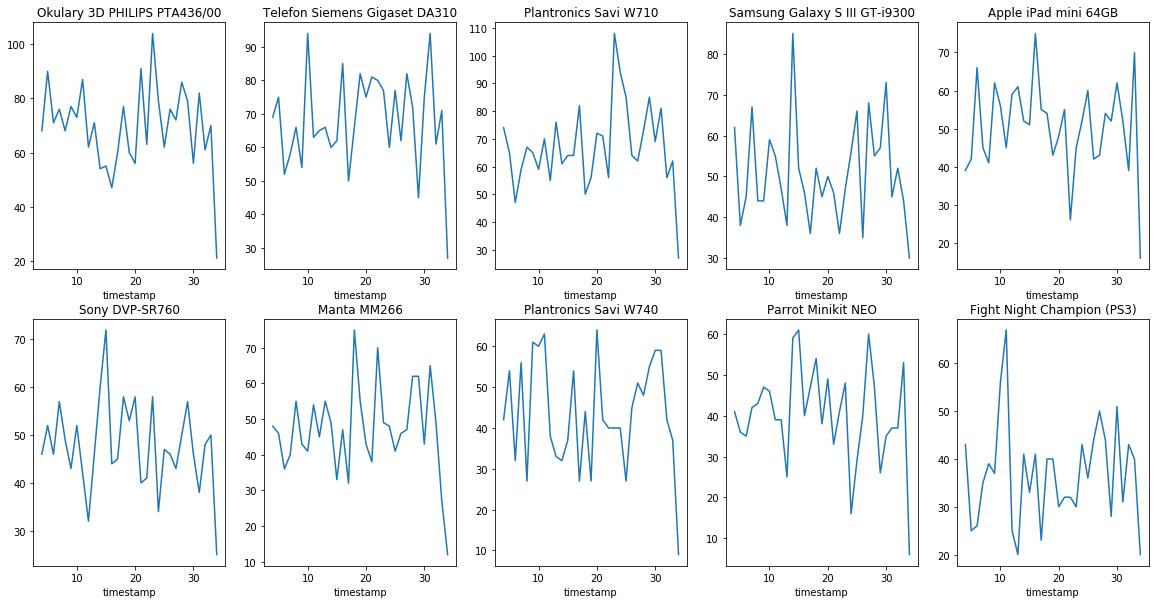

In [47]:
plot_timeseries(df_sessions, 'product_id', df_labels=df_products, labels_column='product_name', n=10)

Z analizy popularności produktów w zależności od daty doszliśmy do wniosku, że nie ma żadnej korelacji między tymi dwoma wartościami. Z wykresów obrazujących te zależności można wywnioskować, że popularność produktów zawsze oscyluje wokół pewnej stałej wartości.

In [48]:
def get_corrcoef_for_column(df, column, n=100):
    cnt = df[column].value_counts()
    idx = cnt.head(n).index
    weeks = range(44)
    
    correlations = []
    
    for i in range(n):
        temp = df[df[column] == idx[i]]
        # ignore if some data is missing
        hours = temp['timestamp'].dt.day * 24 + temp['timestamp'].dt.hour
        hours = hours // 6
        gb = temp.groupby(hours)[column].count()
        array = [gb, hours.unique()]
        correlation = np.corrcoef(array)[1,0]
        print(correlation)
        correlations.append(correlation)
        
    print("\nMaximum correlation found: ", max(correlations))
    print("Minimum correlation found: ", min(correlations))


In [49]:
get_corrcoef_for_column(df_sessions, 'product_id')

-0.05854614581806181
-0.06757282986501072
-0.13106427309240243
-0.24630683593346406
-0.007297509855692793
-0.18297180371481161
0.2251568363577025
0.07337596013685878
0.014969555661102951
-0.10144300732970767
0.030534925803625313
0.11548273730220002
0.007703740379695695
0.17484812482684
-0.195282511650514
0.11326344130698379
-0.4434810267526326
-0.130783699567518
-0.22345379447423047
0.18542308754237752
-0.2423285922843908
-0.014704783100148881
-0.2892023795925332
-0.323438192164969
-0.11918282365569902
-0.36953670983919706
-0.22416664266293326
-0.012866773212024342
-0.10672331028398443
-0.2539765999959859
-0.17754443275532367
-0.13766740592337803
-0.4948946581989591
0.23133456954859236
-0.2240958478968006
-0.10027333886369288
-0.07371887083057947
0.03264724465018821
0.07734957468131401
0.0035649673656458795
0.03395138791185586
0.17543630942125676
-0.28846589633873204
0.1091499491101582
0.15642137350061142
-0.5511205507893419
-0.08773993612534975
0.15569443970273739
-0.02912564837413193

Wyliczenie współczynnika korelacji dla produktów utwierdziło nas we wniosku, że dane nie są skorelowane. Nawet w najbardziej skrajnych przypadkach te korelacje są na tyle delikatne i jest ich tak mało, że wynikają bardziej z losowości. 

In [50]:
df = df_products.set_index('product_id')
df_sessions = df_sessions.dropna(subset=['product_id'])
df_sessions['product_id'] = df_sessions['product_id'].astype(int)
df = df_sessions.join(df, on='product_id')

Unique values in "category_path": 15


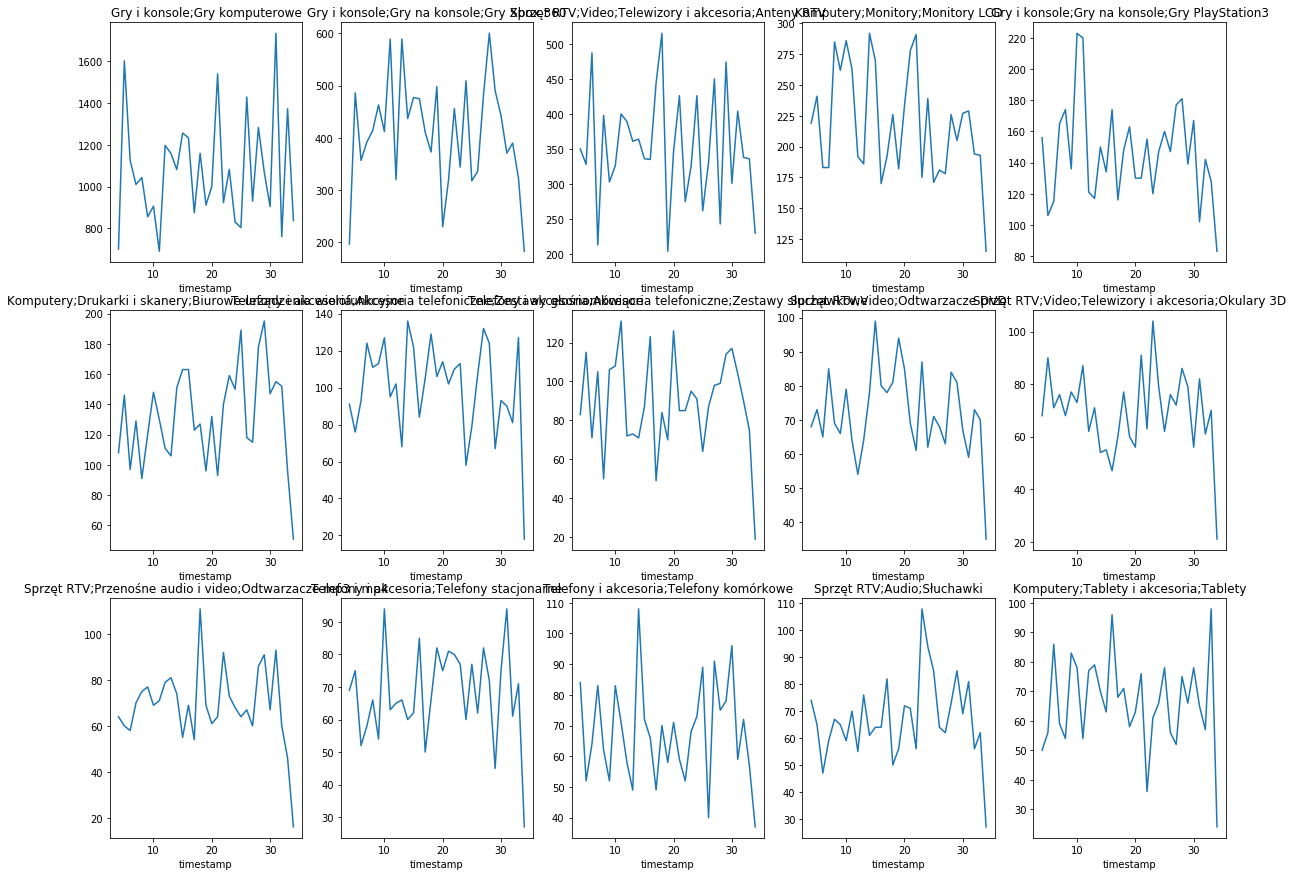

In [51]:
plot_timeseries(df, 'category_path', n=15)

In [52]:
len(df_products['category_path'].str.replace(';.*', '').unique())

4

Unique values in "category_path": 4


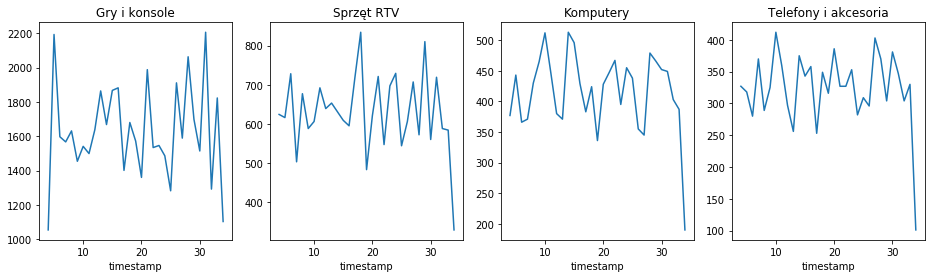

In [53]:
df_new = df.copy()
df_new['category_path'] = df_new['category_path'].str.replace(';.*', '')
plot_timeseries(df_new, 'category_path', n=4)

In [54]:
print("Korelacje dla wszystkich kategorii:")
get_corrcoef_for_column(df, 'category_path', 15)

print("\n\n\n")

print("Korelacje dla ogólnych kategorii:")
get_corrcoef_for_column(df_new, 'category_path', 4)

Korelacje dla wszystkich kategorii:
0.17558817006798863
-0.12738655976119231
-0.07032389170330253
-0.13632844938069394
-0.2224148910259626
0.010027077478116786
0.18757700698138627
-0.08539246588231167
-0.2888840689562362
-0.05854614581806181
0.19636109113243594
-0.06757282986501072
0.01565805110126334
-0.13106427309240243
0.1302419388680979

Maximum correlation found:  0.19636109113243594
Minimum correlation found:  -0.2888840689562362




Korelacje dla ogólnych kategorii:
0.4411982409584468
-0.25278289902986906
-0.24855849598347324
0.05016693920066524

Maximum correlation found:  0.4411982409584468
Minimum correlation found:  -0.25278289902986906


Dla kategorii przeprowadziliśmy analogiczną analizę jak dla pojedynczych produktów. Ponownie nie ma znaczących korelacji. **W związku z tym, że nie ma trendów związanych z datą, to pominiemy ją w naszym modelu.**

<h1>Analiza zniżek</h1>

In [55]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')

In [56]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
3,100001,2021-01-08 11:40:57,102.0,1276,BUY_PRODUCT,15,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [57]:
df.shape

(92980, 10)

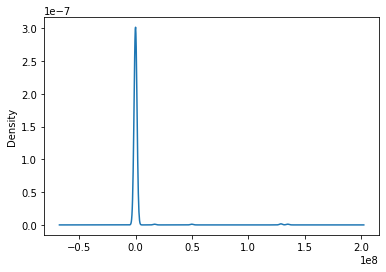

In [58]:
df['price'].plot.density()

Na potrzeby analizy usuwamy błędne ceny.

In [59]:
mask1 = df['price'] > 0
mask2 = df['price'] < 100_000

print('Cen ujemnych:', (~mask1).sum())
print('Cen za dużych:', (~mask2).sum())
print('W sumie usuwamy:', (~mask1).sum() + (~mask2).sum())

Cen ujemnych: 3409
Cen za dużych: 1809
W sumie usuwamy: 5218


In [60]:
df = df[mask1 & mask2]

In [61]:
df.shape

(87762, 10)

Text(0, 0.5, 'mean price')

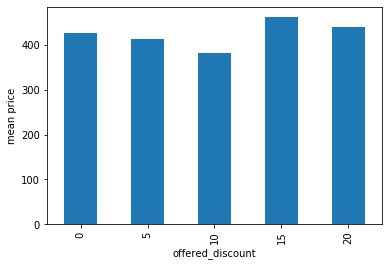

In [62]:
df.groupby('offered_discount')['price'].mean().plot(kind='bar')
plt.ylabel('mean price')

Jak widzimy cena produktu zakupionego przez klienta nie zależy od oferowanej mu zniżki. Nie jest więc tak, że klienci po dostaniu zniżki kupują droższe czy też tańsze produkty niż normalnie.

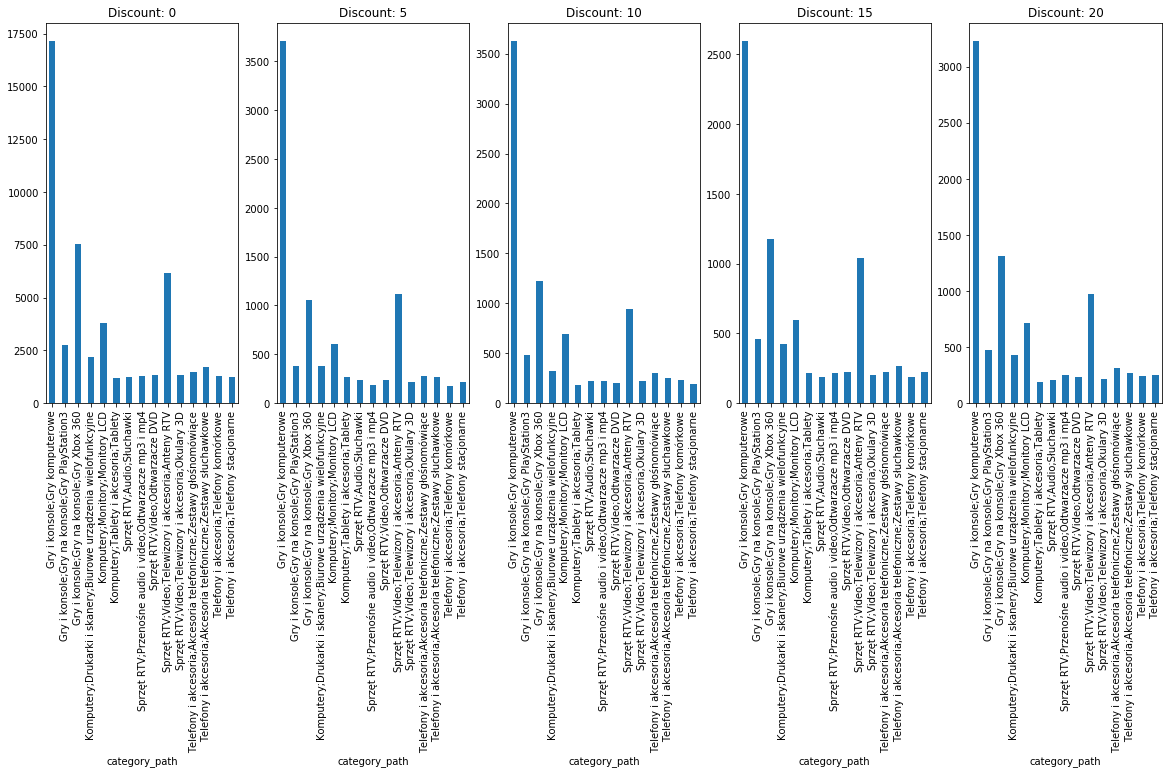

In [63]:
discounts = sorted(df['offered_discount'].unique())

plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

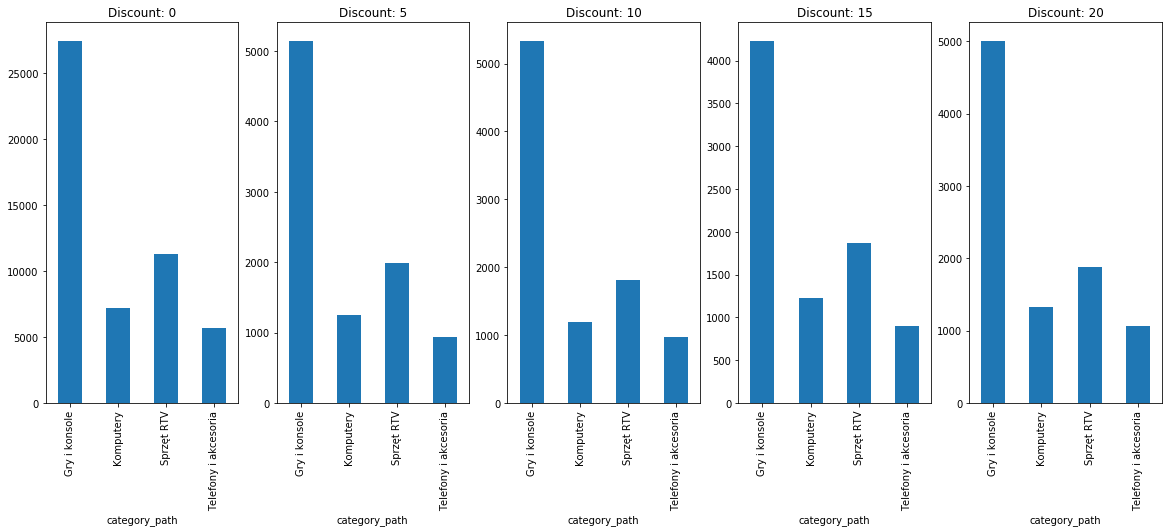

In [64]:
df['category_path'] = df['category_path'].str.replace(';.*', '')
plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

Wygląda na to, że fakt posiadania zniżki nie wpływa też na to, produkty której kategorii klienci kupują. **Ostatecznie stwierdzamy, że zniżka jest nieistotna i nie będziemy jej używać w naszym modelu**.

<h1>Analiza sesji</h1>

In [65]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')
df.shape

(92980, 10)

In [66]:
print('Liczba unikalnych sesji:', len(df['session_id'].unique()))

Liczba unikalnych sesji: 10815


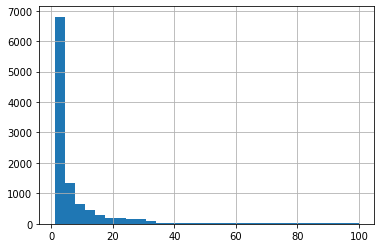

In [67]:
df.groupby('session_id')['session_id'].count().hist(bins=30)

In [68]:
df['category_path'].nunique() # dla upewnienia się

15

In [69]:
unique_categories = df.groupby('session_id')['category_path'].nunique()
unique_categories.max()

1

In [70]:
unique_products_count = df.groupby('session_id')['product_id'].nunique()
products_count = df.groupby('session_id')['product_id'].count()
print(unique_products_count.max(), products_count.max())

98 100


Zauważamy, że w każdej sesji jest przeglądany tylko jeden rodzaj produktów. Na podstawie tego jesteśmy w stanie potwierdzić naszą intuicję, że produkty przeglądane w ramach sesji nie są losowe tylko podobne do przeglądanych wcześniej produktów. 
<br>**Nasz model może zatem wykorzystywać informacje o aktualnej sesji do polecania kolejnych produktów wartych obejrzenia.**

<h1>Analiza użytkowników</h1>

Do dalszej analizy usuwamy rekordy z zakupami - zostawiamy tylko rekordy, gdzie produkt został obejrzany. Robimy to dlatego, że każdy produkt który został zakupiony został wcześniej obejrzany, a my chcemy uniknąć takich powtórek przy kolejnych analizach.

In [71]:
print(df.shape)
df = df[df['event_type'] == 'VIEW_PRODUCT']
print(df.shape)

(92980, 10)
(83919, 10)


In [72]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99
5,100002,2021-01-05 18:12:35,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [73]:
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions['event_type'] == 'VIEW_PRODUCT']
print(df_sessions.shape)

(92980, 7)
(83919, 7)


In [74]:
def get_embeddings(users):
    embeddings = users.groupby(['user_id', 'category_path'])['category_path'].count().unstack(level=1)
    embeddings = embeddings.fillna(0.0)
    embeddings = embeddings.div(embeddings.sum(axis=1), axis=0)
    
    return embeddings

In [75]:
users_embeddings = get_embeddings(df)

In [76]:
users_embeddings.head()

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
user_id,,,,,,,,,,,,,,,
102.0,0.000000,0.000000,0.000000,0.018868,0.283019,0.056604,0.075472,0.000000,0.000000,0.264151,0.037736,0.094340,0.000000,0.094340,0.075472
103.0,0.363985,0.032567,0.009579,0.042146,0.168582,0.005747,0.011494,0.009579,0.007663,0.183908,0.026820,0.040230,0.047893,0.030651,0.019157
104.0,0.036885,0.000000,0.368852,0.000000,0.159836,0.020492,0.004098,0.036885,0.008197,0.225410,0.024590,0.049180,0.028689,0.032787,0.004098
105.0,0.559494,0.012658,0.136709,0.048101,0.046835,0.010127,0.007595,0.007595,0.008861,0.048101,0.018987,0.026582,0.035443,0.024051,0.008861
106.0,0.319742,0.008584,0.182403,0.040773,0.105150,0.008584,0.012876,0.027897,0.006438,0.201717,0.012876,0.010730,0.032189,0.017167,0.012876


In [78]:
users_embeddings.sum(axis=1).head() # Sprawdzenie czy zadziałało

user_id
102.0    1.0
103.0    1.0
104.0    1.0
105.0    1.0
106.0    1.0
dtype: float64

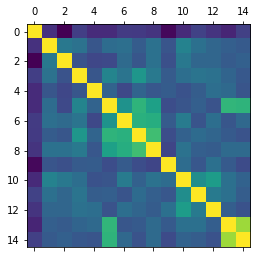

In [79]:
corr = users_embeddings.corr()
plt.matshow(corr)
plt.show()

In [80]:
corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.253070,-0.461976,-0.192551,-0.279655,-0.280426,-0.208442,-0.214920,-0.241542,-0.428195,-0.289624,-0.174479,-0.242616,-0.308414,-0.182701
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.253070,1.000000,0.121223,0.086471,-0.072559,0.052450,0.071817,-0.035737,0.084029,-0.074436,0.188171,0.079059,0.022470,-0.020070,-0.047354
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.461976,0.121223,1.000000,-0.085220,-0.151045,-0.140897,0.044310,-0.068461,0.081590,-0.102908,0.125349,0.019658,0.021553,-0.040594,-0.012325
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.192551,0.086471,-0.085220,1.000000,-0.072655,0.199879,0.101498,0.308534,0.131265,-0.040626,0.064715,0.101207,0.082217,0.006546,-0.061569
Komputery;Monitory;Monitory LCD,-0.279655,-0.072559,-0.151045,-0.072655,1.000000,0.001944,-0.147236,0.007554,-0.062941,-0.034607,-0.091580,-0.031294,0.068980,0.035805,-0.077783
Komputery;Tablety i akcesoria;Tablety,-0.280426,0.052450,-0.140897,0.199879,0.001944,1.000000,0.284763,0.488831,0.368709,-0.116804,-0.078887,-0.021864,-0.086722,0.500262,0.488590
Sprzęt RTV;Audio;Słuchawki,-0.208442,0.071817,0.044310,0.101498,-0.147236,0.284763,1.000000,0.466556,0.447036,-0.042687,0.143755,-0.081582,0.065919,-0.068654,0.031189
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.214920,-0.035737,-0.068461,0.308534,0.007554,0.488831,0.466556,1.000000,0.551790,-0.117310,-0.005260,0.046322,0.014993,-0.046998,-0.086295
Sprzęt RTV;Video;Odtwarzacze DVD,-0.241542,0.084029,0.081590,0.131265,-0.062941,0.368709,0.447036,0.551790,1.000000,-0.156809,0.087139,-0.018360,-0.033820,0.042306,0.041125


In [81]:
corr[corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.174479
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.188171
Gry i konsole;Gry na konsole;Gry Xbox 360                            0.125349
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.308534
Komputery;Monitory;Monitory LCD                                      0.068980
Komputery;Tablety i akcesoria;Tablety                                0.500262
Sprzęt RTV;Audio;Słuchawki                                           0.466556
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.551790
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.551790
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                   0.077982
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.346687
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.255258
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [82]:
corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.461976
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.253070
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.461976
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.192551
Komputery;Monitory;Monitory LCD                                     -0.279655
Komputery;Tablety i akcesoria;Tablety                               -0.280426
Sprzęt RTV;Audio;Słuchawki                                          -0.208442
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.214920
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.241542
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.428195
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.289624
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.174479
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

Stwórzmy teraz syntetyczny dataset z użytkownikami w celu sprawdzenia, czy wybieranie losowo sesji da nam podobne korelacje, co te prawdziwe.

In [84]:
import random

def generate_users(n_users):
    users_sessions = df.groupby('user_id')['session_id'].nunique()
    sessions = df['session_id'].unique()

    generated_sessions = {'user_id': [], 'session_id': []}
    for i in range(n_users):
        idx = random.sample(list(sessions), users_sessions.iloc[i % len(users_sessions)])
        for index in idx:
            generated_sessions['user_id'].append(i)
            generated_sessions['session_id'].append(index)

    generated_sessions = pd.DataFrame(generated_sessions)
    
    df_gen = generated_sessions.set_index('session_id')
    df_gen = df_sessions.drop(columns='user_id').join(df_gen, on='session_id')
    df_temp = df_products.set_index('product_id')
    df_gen = df_gen.join(df_temp, on='product_id')
    return df_gen

In [85]:
# it can take up to a minute
gen_users = generate_users(len(users_embeddings) * 100) # * 100 to generate larger sample
gen_users_embeddings = get_embeddings(gen_users) 

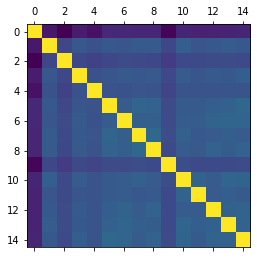

In [86]:
gen_corr = gen_users_embeddings.corr()
plt.matshow(gen_corr)
plt.show()

In [87]:
gen_corr.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,1.000000,-0.264570,-0.355698,-0.254737,-0.287567,-0.201940,-0.201399,-0.207495,-0.210911,-0.338017,-0.215134,-0.226779,-0.223900,-0.219821,-0.217722
Gry i konsole;Gry na konsole;Gry PlayStation3,-0.264570,1.000000,-0.067545,0.013426,-0.015030,0.017470,0.007917,0.025627,0.029243,-0.063630,0.046837,0.002217,0.016262,0.040220,0.019834
Gry i konsole;Gry na konsole;Gry Xbox 360,-0.355698,-0.067545,1.000000,-0.059661,-0.091322,-0.064752,-0.045813,-0.057473,-0.060806,-0.114641,-0.055348,-0.048832,-0.043195,-0.041459,-0.055204
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,-0.254737,0.013426,-0.059661,1.000000,-0.013661,0.004725,0.029069,0.015577,0.023285,-0.057756,0.032028,0.005445,0.026396,0.018691,0.049542
Komputery;Monitory;Monitory LCD,-0.287567,-0.015030,-0.091322,-0.013661,1.000000,-0.008359,-0.013388,0.003457,-0.006939,-0.073913,-0.009153,-0.002720,-0.005243,-0.001029,-0.005584
Komputery;Tablety i akcesoria;Tablety,-0.201940,0.017470,-0.064752,0.004725,-0.008359,1.000000,0.037338,0.085297,0.071973,-0.041702,0.029995,0.030693,0.046943,0.062077,0.097204
Sprzęt RTV;Audio;Słuchawki,-0.201399,0.007917,-0.045813,0.029069,-0.013388,0.037338,1.000000,0.053787,0.053311,-0.041122,0.037027,0.040995,0.076966,0.086677,0.084186
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,-0.207495,0.025627,-0.057473,0.015577,0.003457,0.085297,0.053787,1.000000,0.097758,-0.035134,0.057424,0.011846,0.035844,0.054048,0.033885
Sprzęt RTV;Video;Odtwarzacze DVD,-0.210911,0.029243,-0.060806,0.023285,-0.006939,0.071973,0.053311,0.097758,1.000000,-0.053232,0.031550,0.021834,0.070633,0.043913,0.068443


In [88]:
gen_corr[gen_corr!=1.0].max()

category_path
Gry i konsole;Gry komputerowe                                       -0.201399
Gry i konsole;Gry na konsole;Gry PlayStation3                        0.046837
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.041459
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       0.049542
Komputery;Monitory;Monitory LCD                                      0.003457
Komputery;Tablety i akcesoria;Tablety                                0.097204
Sprzęt RTV;Audio;Słuchawki                                           0.086677
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4             0.097758
Sprzęt RTV;Video;Odtwarzacze DVD                                     0.097758
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.028347
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                   0.085017
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące    0.074684
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [89]:
gen_corr.min()

category_path
Gry i konsole;Gry komputerowe                                       -0.355698
Gry i konsole;Gry na konsole;Gry PlayStation3                       -0.264570
Gry i konsole;Gry na konsole;Gry Xbox 360                           -0.355698
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne      -0.254737
Komputery;Monitory;Monitory LCD                                     -0.287567
Komputery;Tablety i akcesoria;Tablety                               -0.201940
Sprzęt RTV;Audio;Słuchawki                                          -0.201399
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4            -0.207495
Sprzęt RTV;Video;Odtwarzacze DVD                                    -0.210911
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                  -0.338017
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                  -0.215134
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące   -0.226779
Telefony i akcesoria;Akcesoria telefoniczne;Zestaw

In [90]:
corr_diff = (gen_corr - corr).abs()
corr_diff.style.background_gradient(cmap='coolwarm')

category_path,Gry i konsole;Gry komputerowe,Gry i konsole;Gry na konsole;Gry PlayStation3,Gry i konsole;Gry na konsole;Gry Xbox 360,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,Komputery;Monitory;Monitory LCD,Komputery;Tablety i akcesoria;Tablety,Sprzęt RTV;Audio;Słuchawki,Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,Sprzęt RTV;Video;Odtwarzacze DVD,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV,Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,Telefony i akcesoria;Telefony komórkowe,Telefony i akcesoria;Telefony stacjonarne
category_path,,,,,,,,,,,,,,,
Gry i konsole;Gry komputerowe,0.000000,0.011500,0.106278,0.062186,0.007912,0.078486,0.007044,0.007425,0.030631,0.090179,0.074490,0.052300,0.018716,0.088593,0.035021
Gry i konsole;Gry na konsole;Gry PlayStation3,0.011500,0.000000,0.188768,0.073045,0.057529,0.034979,0.063900,0.061365,0.054786,0.010806,0.141333,0.076842,0.006208,0.060290,0.067188
Gry i konsole;Gry na konsole;Gry Xbox 360,0.106278,0.188768,0.000000,0.025559,0.059723,0.076146,0.090124,0.010988,0.142396,0.011733,0.180697,0.068490,0.064748,0.000865,0.042879
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,0.062186,0.073045,0.025559,0.000000,0.058994,0.195154,0.072429,0.292957,0.107980,0.017130,0.032687,0.095762,0.055821,0.012145,0.111111
Komputery;Monitory;Monitory LCD,0.007912,0.057529,0.059723,0.058994,0.000000,0.010303,0.133848,0.004097,0.056003,0.039306,0.082427,0.028574,0.074223,0.036835,0.072200
Komputery;Tablety i akcesoria;Tablety,0.078486,0.034979,0.076146,0.195154,0.010303,0.000000,0.247425,0.403534,0.296737,0.075102,0.108882,0.052557,0.133664,0.438184,0.391386
Sprzęt RTV;Audio;Słuchawki,0.007044,0.063900,0.090124,0.072429,0.133848,0.247425,0.000000,0.412769,0.393724,0.001565,0.106728,0.122577,0.011046,0.155331,0.052997
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,0.007425,0.061365,0.010988,0.292957,0.004097,0.403534,0.412769,0.000000,0.454032,0.082176,0.062683,0.034476,0.020852,0.101046,0.120180
Sprzęt RTV;Video;Odtwarzacze DVD,0.030631,0.054786,0.142396,0.107980,0.056003,0.296737,0.393724,0.454032,0.000000,0.103577,0.055589,0.040194,0.104453,0.001606,0.027318


In [91]:
corr_diff_max = corr_diff.max().max()
corr_diff_max

0.7148854902142306

In [92]:
corr_diff_mean = corr_diff.mean().mean()
corr_diff_mean

0.09425328069486875

Wygenerujemy teraz embeddingi dla takiej samej ilości użytkowników, jaką mamy w dataset'cie. Dzięki temu sprawdzimy, czy różnice między naszymi korelacjami dla embeddingów prawdziwych użytkowników i tych wygenerowanych mogą być efektem losowości.

In [93]:
# it can take up to a minute

max_diffs = []
mean_diffs = []
unique_categories_counts = []
n_iterations = 100

for i in range(n_iterations):
    temp_users = generate_users(len(users_embeddings))
    temp_embeddings = get_embeddings(temp_users)
    temp_corr = temp_embeddings.corr()
    temp_corr_diff = (gen_corr - temp_corr).abs()
    
    max_diff = temp_corr_diff.max().max()
    mean_diff = temp_corr_diff.mean().mean()
    max_diffs.append(max_diff)
    mean_diffs.append(mean_diff)
    
    temp_unique_categories_count = temp_users.groupby('user_id')['category_path'].nunique().mean()
    unique_categories_counts.append(temp_unique_categories_count)

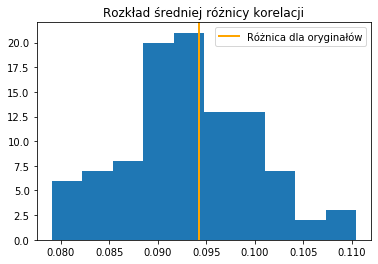

In [94]:
plt.hist(mean_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_mean, color='orange', linewidth=2)
plt.title('Rozkład średniej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

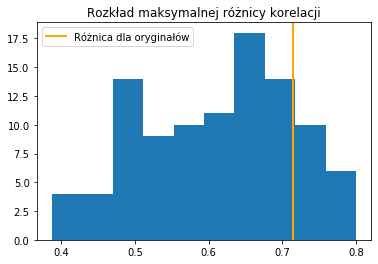

In [96]:
plt.hist(max_diffs, bins=int(n_iterations ** 0.5))
plt.axvline(corr_diff_max, color='orange', linewidth=2)
plt.title('Rozkład maksymalnej różnicy korelacji')
plt.legend(['Różnica dla oryginałów'])
plt.show()

In [97]:
original_categories_counts = df.groupby('user_id')['category_path'].nunique().mean()
original_categories_counts

13.245

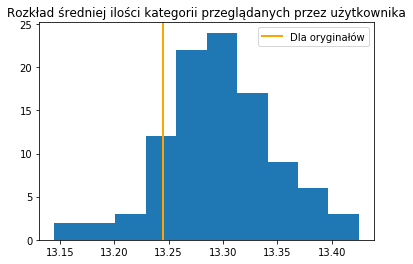

In [99]:
plt.hist(unique_categories_counts, bins=int(n_iterations ** 0.5))
plt.axvline(original_categories_counts, color='orange', linewidth=2)
plt.title('Rozkład średniej ilości kategorii przeglądanych przez użytkownika')
plt.legend(['Dla oryginałów'])
plt.show()

Jak widać korelacje dla prawdziwych użytkowników niewiele różnią się od korelacji dla wygenerowanych użytkowników - można uznać, że różnica ta jest spowodowana losowością. Z tego wynika, wbrew naszym oczekiwaniom, że użytkownicy nie mają żadnych preferencji co do kategorii produktów, które oglądają. Możemy uznać więc, że historia użytkownika nie dostarcza nam żadnych nowych informacji, a system polecania warto robić używając jedynie historii aktualnej sesji.

<h1>Analiza rozkładów przedmiotów</h1>

In [100]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001,2021-01-08 11:35:40,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001,2021-01-08 11:38:48,102.0,1277,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02
2,100001,2021-01-08 11:40:32,102.0,1276,VIEW_PRODUCT,15,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
4,100002,2021-01-05 18:08:21,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99
5,100002,2021-01-05 18:12:35,102.0,1283,VIEW_PRODUCT,0,NaN,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


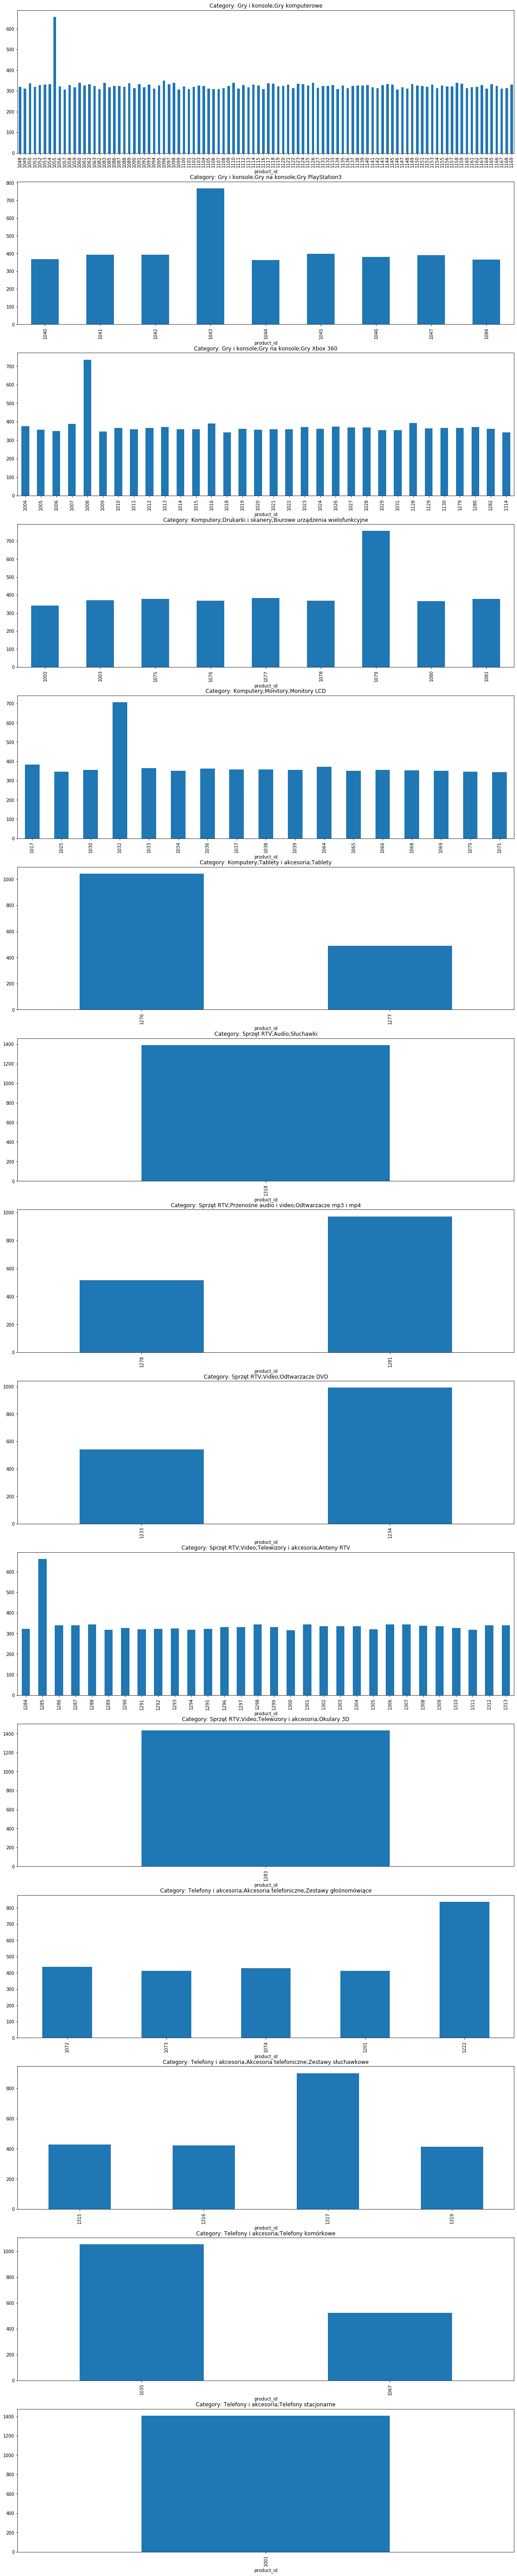

In [101]:
categories = sorted(df['category_path'].unique())

plt.figure(figsize=(20, len(categories) * 7))
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    plt.title(f'Category: {category}')
    temp = df[df['category_path'] == category]
    temp.groupby(['product_id'])['product_id'].count().plot(kind='bar')
plt.show()

In [102]:
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
print(df_sessions.shape)
df_sessions = df_sessions[df_sessions["product_id"].notna()]
print(df_sessions.shape)

(97900, 7)
(93014, 7)


In [103]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-01-08T11:35:40,102.0,1276.0,VIEW_PRODUCT,15,NaN
1,100001,2021-01-08T11:38:48,102.0,1277.0,VIEW_PRODUCT,15,NaN
2,100001,2021-01-08T11:40:32,102.0,1276.0,VIEW_PRODUCT,15,NaN
3,100001,2021-01-08T11:40:57,102.0,1276.0,BUY_PRODUCT,15,20001.0
4,100002,2021-01-05T18:08:21,102.0,1283.0,VIEW_PRODUCT,0,NaN


In [104]:
df_sessions = df_sessions[df_sessions['event_type'] == 'BUY_PRODUCT']
df = df_products.set_index('product_id')
df_sessions = df_sessions.dropna(subset=['product_id'])
df_sessions['product_id'] = df_sessions['product_id'].astype(int)
df = df_sessions.join(df, on='product_id')

In [105]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
3,100001,2021-01-08T11:40:57,102.0,1276,BUY_PRODUCT,15,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
6,100002,2021-01-05T18:12:53,102.0,1283,BUY_PRODUCT,0,20002.0,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99
23,100004,2021-01-03T23:56:37,102.0,1032,BUY_PRODUCT,10,20003.0,LCD Iiyama E2280WSD,Komputery;Monitory;Monitory LCD,688.78
29,100005,2021-01-08T09:35:39,102.0,1222,BUY_PRODUCT,5,20004.0,Parrot Minikit NEO,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,245.00
32,100006,2021-01-01T21:59:21,102.0,1318,BUY_PRODUCT,10,20005.0,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00


In [106]:
df['event_type'].unique()

array(['BUY_PRODUCT'], dtype=object)

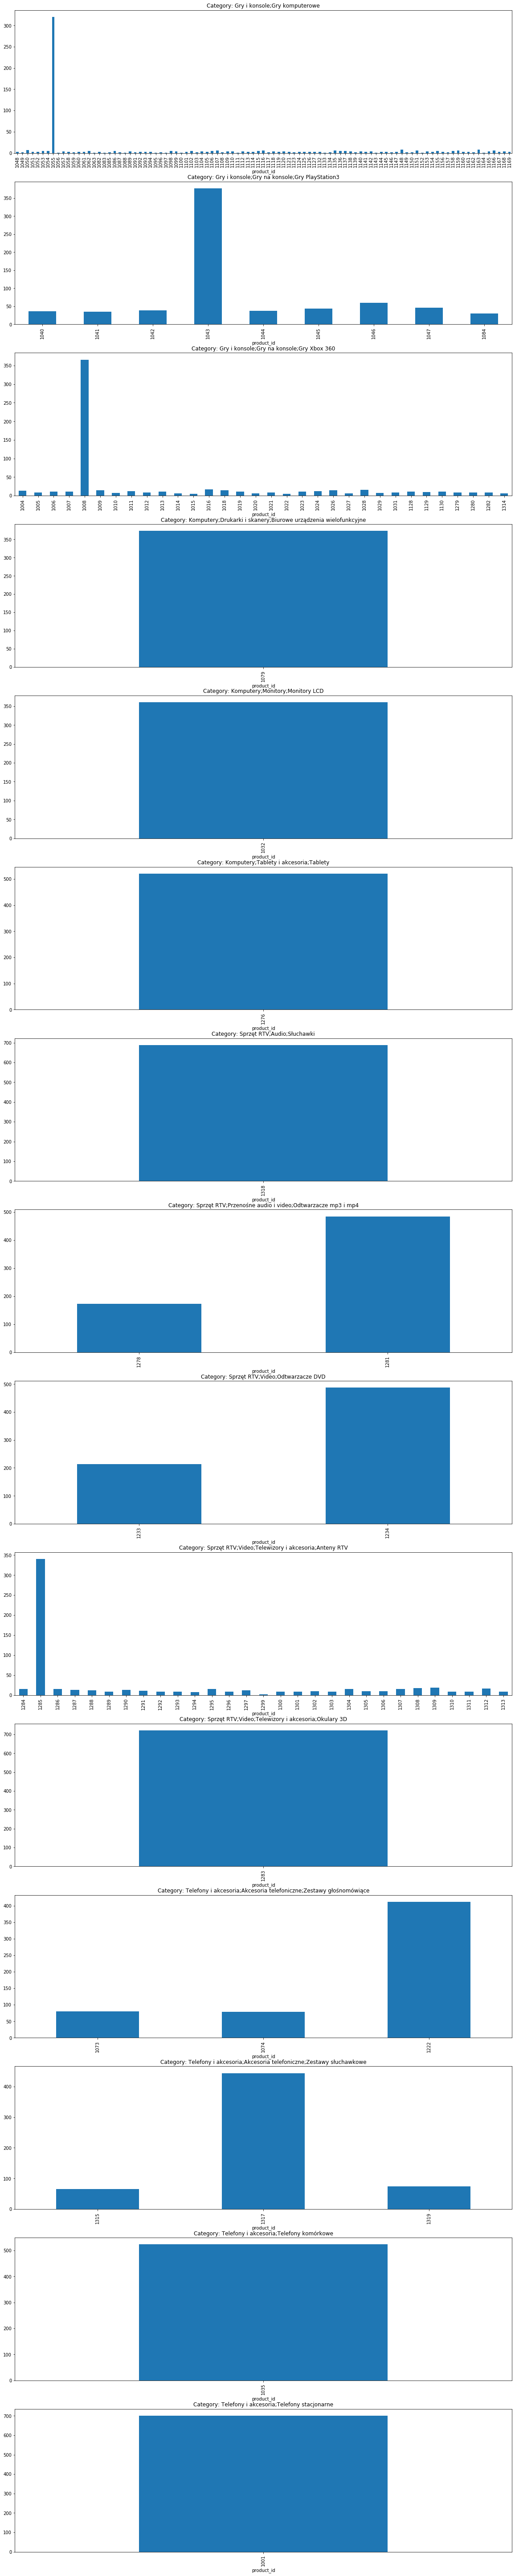

In [107]:
categories = sorted(df['category_path'].unique())

plt.figure(figsize=(20, len(categories) * 7))
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    plt.title(f'Category: {category}')
    temp = df[df['category_path'] == category]
    temp.groupby(['product_id'])['product_id'].count().plot(kind='bar')
plt.show()